In [6]:
import csv
import os
import copy
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import warnings
from scipy import interpolate
import arviz as az

In [7]:
model_spec = {
    "continuous_covariates" : [
        'precip_annual_std_[weight]',
        'precip_annual_std_[weight]_2',
        'precip_annual_std_[weight]_3',
        'temp_[weight]',
        'temp_[weight]_2', 
        'temp_[weight]_3'
    ],
    "discrete_covariates" : ['drought'],
    "fixed_effects" : ["year"],
    "incremental_effects" : 0,
    "weights" : "pop_weighted",
    "target" : "fd_ln_gdp"
}

In [71]:
country_splines = {}
for country in list(set(gdp_regression_data_insample.country)):
    country_data = gdp_regression_data_insample.loc[(gdp_regression_data_insample.country == country)]
    spline = interpolate.UnivariateSpline(country_data.year, country_data[model_spec["target"]], k=4)
    country_splines[country] = spline

In [8]:
pred_int_acc_cv = []
mse_cv = []

for i in range(1):

    gdp_regression_data_insample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_insample_festratified_{i}.csv").reset_index(drop=True)
    gdp_regression_data_outsample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_outsample_festratified_{i}.csv").reset_index(drop=True).sort_values(by="fd_ln_gdp")

    vars_to_grab = []
    for covar in model_spec["continuous_covariates"]:
        vars_to_grab.append(covar.replace("[weight]",model_spec["weights"]))
    for covar in model_spec["discrete_covariates"]:
        vars_to_grab.append(covar)
    for i in range(model_spec["incremental_effects"]):
        for ie_col in [col for col in gdp_regression_data_insample.columns if col.endswith(f"incremental_effect_{i+1}")]:
            vars_to_grab.append(ie_col)
    for fe in model_spec["fixed_effects"]:
        for fe_col in [col for col in gdp_regression_data_insample.columns if f"{fe}_fixed_effect" in col]:
            vars_to_grab.append(fe_col)
    
    in_sample_model_data = gdp_regression_data_insample[vars_to_grab]
    out_sample_model_data = gdp_regression_data_outsample[vars_to_grab]
    
    model = sm.OLS(gdp_regression_data_insample[model_spec["target"]],in_sample_model_data)
    regression = model.fit()
    pred_int_acc = []
    predictions = regression.get_prediction(out_sample_model_data)
    lowers, uppers, real_y_vals = [], [], []
    for index, row in enumerate(gdp_regression_data_outsample.itertuples()):
        real_y = row.fd_ln_gdp
        # prediction = prediction + country_splines[row.country](row.year)
        prediction = predictions.predicted_mean[index]
        prediction_variance = np.sqrt(predictions.var_pred_mean[index])
        lowers.append(prediction - (prediction_variance * 1.9603795))
        uppers.append(prediction + (prediction_variance * 1.9603795))
        real_y_vals.append(real_y)
        if uppers[-1] >= real_y and lowers[-1] <= real_y:
            pred_int_acc.append(1)
        else:
            pred_int_acc.append(0)

    pred_int_acc_cv.append(np.mean(pred_int_acc))
    mse_cv.append(np.mean(np.square(predictions.predicted_mean - gdp_regression_data_outsample.fd_ln_gdp)))
            
print("Prediction interval accuracy:", np.mean(pred_int_acc_cv))
print("MSE:", np.mean(mse_cv))

Prediction interval accuracy: 0.31014150943396224
MSE: 0.016737980914587034


# Bayesian models

In [47]:
fe_bayes_model = pd.read_pickle("../output/models/bayes_models/fixed_effects_model.pkl")
var_list = fe_bayes_model["variables_list"]
continuous_vars = var_list[0:34]
discrete_vars = var_list[34:38]
fixed_effect_vars = [col for col in var_list if "fixed_effect" in col]
incremental_effect_vars = [col for col in var_list if "incremental_effect" in col]

## Check model convergence

In [112]:
az.summary(fe_bayes_model["trace"], var_names=["model_variable_coefs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_variable_coefs[0],-0.143,0.162,-0.397,0.086,0.074,0.056,5.0,31.0,2.25
model_variable_coefs[1],0.240,0.323,-0.227,0.707,0.148,0.113,5.0,19.0,2.26
model_variable_coefs[2],-0.133,0.177,-0.381,0.136,0.080,0.061,5.0,16.0,2.12
model_variable_coefs[3],0.161,0.277,-0.077,0.730,0.136,0.104,7.0,11.0,1.63
model_variable_coefs[4],-0.159,0.287,-0.741,0.084,0.141,0.108,7.0,11.0,1.62
...,...,...,...,...,...,...,...,...,...
model_variable_coefs[759],-0.000,0.000,-0.000,0.000,0.000,0.000,5.0,16.0,2.29
model_variable_coefs[760],-0.000,0.000,-0.000,0.000,0.000,0.000,6.0,14.0,1.67
model_variable_coefs[761],0.000,0.000,-0.000,0.000,0.000,0.000,5.0,25.0,2.22
model_variable_coefs[762],0.000,0.000,-0.000,0.000,0.000,0.000,5.0,24.0,2.38


/tmp/ipykernel_31125/1287660087.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


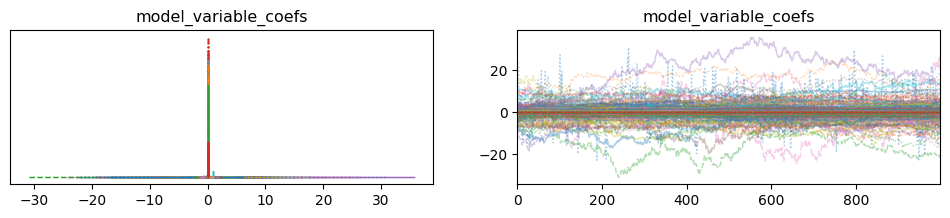

In [113]:
fig = az.plot_trace(fe_bayes_model["trace"], var_names=["model_variable_coefs"]).ravel()[0].figure
fig.show()

## Unscale

In [93]:
gdp_regression_data_insample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_insample_festratified_0.csv")
gdp_regression_data_outsample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_outsample_festratified_0.csv")
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(var_list):
    scaled_vars[var] = fe_bayes_model["posterior"].posterior.model_variable_coefs[:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    # TODO: Note this is not exactly correct in the case of ^2 and ^3 vars
    if var in continuous_vars:
        if "_scaled" in var:
            var = var.replace("_scaled","")
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp) / np.std(gdp_regression_data_insample[var])
    else:
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp)

## Predict

In [5]:
bayes_mse = []
bayes_pred_int_acc = []
for row in gdp_regression_data_outsample.iterrows():
    row = row[1]
    prediction = []
    for var in var_list:
        if "_scaled" in var:
            var = var.replace("_scaled","")
        prediction.append(unscaled_vars[var] * getattr(row, var))
    prediction = np.sum(prediction, axis=0)
    bayes_mse.append(np.mean(np.square(np.array(np.mean(prediction, axis=0)) - row.fd_ln_gdp)))
print(np.mean(bayes_mse))

NameError: name 'model_data' is not defined

# Burke temp threshold 

In [ ]:
first_country_fe_col = [col for col in gdp_regression_data_insample.columns if "country_fixed_effect" in col][0]
first_year_fe_col = [col for col in gdp_regression_data_insample.columns if "year_fixed_effect" in col][0]
gdp_regression_data_insample[first_country_fe_col] = 0
gdp_regression_data_insample[first_year_fe_col] = 0
gdp_regression_data_outsample[first_country_fe_col] = 0
gdp_regression_data_outsample[first_year_fe_col] = 0

In [32]:
cov_mat = regression.cov_params()
coef1 = regression.params.temp_pop_weighted
coef2 = regression.params.temp_pop_weighted_2
temp_var = cov_mat.iloc[0,0]
temp_2_var = cov_mat.iloc[1,1]
t_t2_covar = cov_mat.iloc[0,1]
vertex_variance = .25 * ((coef1/coef2) * (coef1/coef2)) * ((temp_var/np.square(coef1)) + (temp_2_var/np.square(coef2))-(2*(t_t2_covar/(coef1*coef2))))
vertex = coef1 / (-2 * coef2)
print(vertex - (1.645 * np.sqrt(vertex_variance)))
print(vertex + (1.645 * np.sqrt(vertex_variance)))
# TODO: try this in Stata to see how results change

0.9371830468792268
41.478841586848915


(-0.5, 0.5)

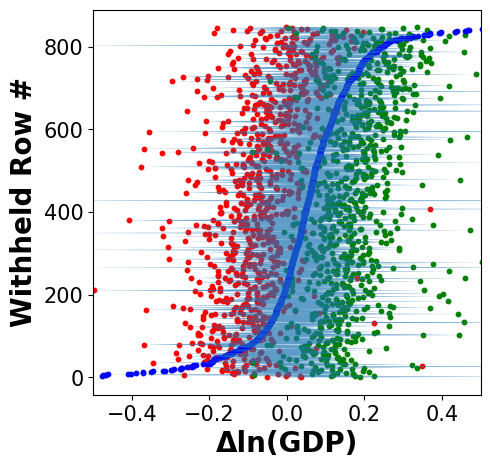

In [160]:
import matplotlib.patches as patches
fig, axis = plt.subplots(1,1, figsize=(5,5))
axis.scatter(lowers, list(range(len(lowers))), color="red", s=10)
axis.scatter(uppers, list(range(len(lowers))), color="green", s=10)
axis.scatter(real_y_vals, list(range(len(lowers))), color="blue", s=10)
last_line = None
for index in range(len(lowers)):
    if last_line != None:
        axis.add_patch(
            patches.Polygon(
                xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
            )
        )
    last_line = [lowers[index],uppers[index]]
axis.set_xlabel("Δln(GDP)", weight="bold")
axis.set_ylabel("Withheld Row #", weight="bold")
axis.xaxis.label.set_size(20)
axis.yaxis.label.set_size(20)#
axis.xaxis.set_tick_params(labelsize=15)
axis.yaxis.set_tick_params(labelsize=15)
axis.title.set_size(25)
axis.set_xlim(-.5, .5)

# all vars

(-0.5, 0.5)

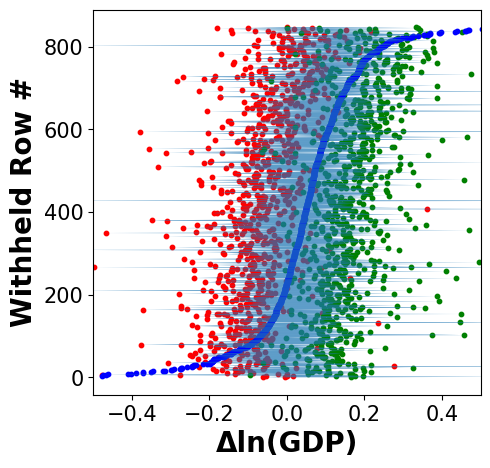

In [146]:
import matplotlib.patches as patches
fig, axis = plt.subplots(1,1, figsize=(5,5))
axis.scatter(lowers, list(range(len(lowers))), color="red", s=10)
axis.scatter(uppers, list(range(len(lowers))), color="green", s=10)
axis.scatter(real_y_vals, list(range(len(lowers))), color="blue", s=10)
last_line = None
for index in range(len(lowers)):
    if last_line != None:
        axis.add_patch(
            patches.Polygon(
                xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
            )
        )
    last_line = [lowers[index],uppers[index]]
axis.set_xlabel("Δln(GDP)", weight="bold")
axis.set_ylabel("Withheld Row #", weight="bold")
axis.xaxis.label.set_size(20)
axis.yaxis.label.set_size(20)
axis.xaxis.set_tick_params(labelsize=15)
axis.yaxis.set_tick_params(labelsize=15)
axis.title.set_size(25)
axis.set_xlim(-.5, .5)

# ie == 5

(-0.5, 0.5)

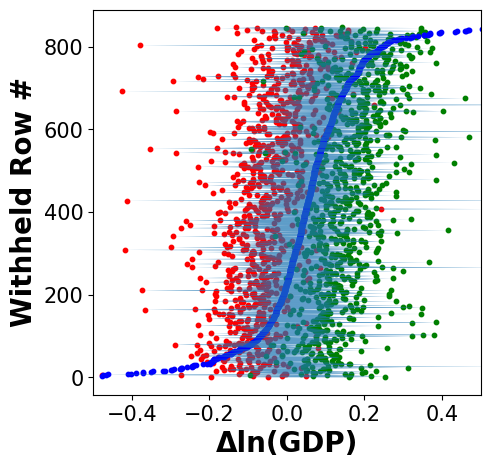

In [142]:
import matplotlib.patches as patches
fig, axis = plt.subplots(1,1, figsize=(5,5))
axis.scatter(lowers, list(range(len(lowers))), color="red", s=10)
axis.scatter(uppers, list(range(len(lowers))), color="green", s=10)
axis.scatter(real_y_vals, list(range(len(lowers))), color="blue", s=10)
last_line = None
for index in range(len(lowers)):
    if last_line != None:
        axis.add_patch(
            patches.Polygon(
                xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
            )
        )
    last_line = [lowers[index],uppers[index]]
axis.set_xlabel("Δln(GDP)", weight="bold")
axis.set_ylabel("Withheld Row #", weight="bold")
axis.xaxis.label.set_size(20)
axis.yaxis.label.set_size(20)
axis.xaxis.set_tick_params(labelsize=15)
axis.yaxis.set_tick_params(labelsize=15)
axis.title.set_size(25)
axis.set_xlim(-.5, .5)

# ie == 4

(-0.5, 0.5)

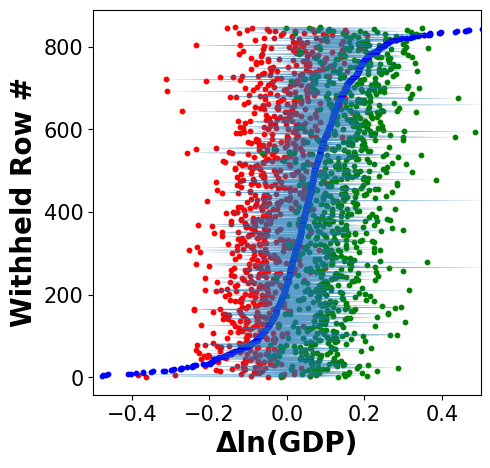

In [138]:
import matplotlib.patches as patches
fig, axis = plt.subplots(1,1, figsize=(5,5))
axis.scatter(lowers, list(range(len(lowers))), color="red", s=10)
axis.scatter(uppers, list(range(len(lowers))), color="green", s=10)
axis.scatter(real_y_vals, list(range(len(lowers))), color="blue", s=10)
last_line = None
for index in range(len(lowers)):
    if last_line != None:
        axis.add_patch(
            patches.Polygon(
                xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
            )
        )
    last_line = [lowers[index],uppers[index]]
axis.set_xlabel("Δln(GDP)", weight="bold")
axis.set_ylabel("Withheld Row #", weight="bold")
axis.xaxis.label.set_size(20)
axis.yaxis.label.set_size(20)
axis.xaxis.set_tick_params(labelsize=15)
axis.yaxis.set_tick_params(labelsize=15)
axis.title.set_size(25)
axis.set_xlim(-.5, .5)

# ie == 3

(-0.5, 0.5)

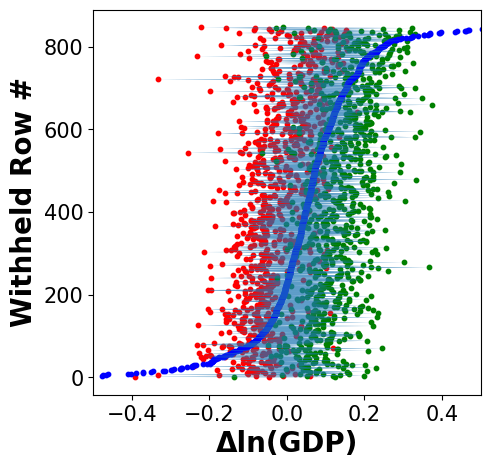

In [134]:
import matplotlib.patches as patches
fig, axis = plt.subplots(1,1, figsize=(5,5))
axis.scatter(lowers, list(range(len(lowers))), color="red", s=10)
axis.scatter(uppers, list(range(len(lowers))), color="green", s=10)
axis.scatter(real_y_vals, list(range(len(lowers))), color="blue", s=10)
last_line = None
for index in range(len(lowers)):
    if last_line != None:
        axis.add_patch(
            patches.Polygon(
                xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
            )
        )
    last_line = [lowers[index],uppers[index]]
axis.set_xlabel("Δln(GDP)", weight="bold")
axis.set_ylabel("Withheld Row #", weight="bold")
axis.xaxis.label.set_size(20)
axis.yaxis.label.set_size(20)
axis.xaxis.set_tick_params(labelsize=15)
axis.yaxis.set_tick_params(labelsize=15)
axis.title.set_size(25)
axis.set_xlim(-.5, .5)

# ie == 2

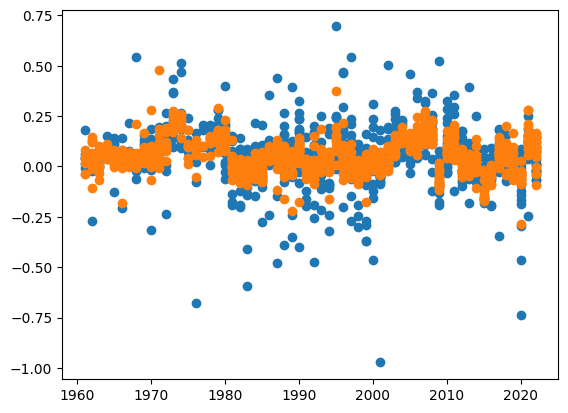

In [82]:
plt.scatter(
    gdp_regression_data_outsample["year"], 
    gdp_regression_data_outsample[model_spec["target"]]
)
plt.scatter(
    gdp_regression_data_outsample["year"], 
    predictions.predicted_mean
)
plt.show()

In [84]:
gdp_regression_data_insample = pd.read_csv("../data/regression/cross_validation/gdp_regression_data_insample_festratified_0.csv").reset_index(drop=True)

for i in range(4):
    model_spec = {
        "continuous_covariates" : [
            'temp_[weight]', 'temp_[weight]_2',
        ],
        "discrete_covariates" : [],
        "fixed_effects" : [],
        "incremental_effects" : i,
        "weights" : "unweighted",
        "target" : "fd_ln_gdp"
    }
    
    vars_to_grab = []
    for covar in model_spec["continuous_covariates"]:
        vars_to_grab.append(covar.replace("[weight]",model_spec["weights"]))
    for covar in model_spec["discrete_covariates"]:
        vars_to_grab.append(covar)
    for i in range(model_spec["incremental_effects"]):
        for ie_col in [col for col in gdp_regression_data_insample.columns if col.endswith(f"incremental_effect_{i+1}")]:
            vars_to_grab.append(ie_col)
    for fe in model_spec["fixed_effects"]:
        for fe_col in [col for col in gdp_regression_data_insample.columns if f"{fe}_fixed_effect" in col]:
            vars_to_grab.append(fe_col)
    
    in_sample_model_data = gdp_regression_data_insample[vars_to_grab]
    out_sample_model_data = gdp_regression_data_outsample[vars_to_grab]
    
    model = sm.OLS(gdp_regression_data_insample[model_spec["target"]],in_sample_model_data)
    regression = model.fit()
    
    cov_mat = np.array(regression.cov_params())

    print("cov mat")
    print(cov_mat[0][0], cov_mat[0][1])
    print(cov_mat[1][0], cov_mat[1][1])
    
    first_row = list(out_sample_model_data.iloc[0])
    first_row_transpose = np.transpose(first_row)
    
    topleft = first_row[0] * cov_mat[0][0]
    topright = first_row[1] * cov_mat[1][0]
    bottomleft = first_row[0] * cov_mat[0][1]
    bottomright = first_row[1] * cov_mat[1][1]
    
    res1 = topleft + topright
    res2 = bottomleft + bottomright
    
    mat1 = [res1, res2]
    
    result = (mat1[0] * first_row_transpose[0]) + (mat1[1] * first_row_transpose[1])
    print("first row pred err:", np.sqrt(result))

cov mat
2.667741702589398e-07 -1.1138011719798671e-08
-1.1138011719798671e-08 4.816329332223123e-10
first row pred err: 0.002178733686129194
cov mat
1.4205824293970468e-06 -6.03597661616206e-08
-6.03597661616206e-08 2.652250645901446e-09
first row pred err: 0.004873465335476806
cov mat
3.467028021923174e-06 -1.4690956259498875e-07
-1.4690956259498875e-07 6.446364646918727e-09
first row pred err: 0.007765895122026455
cov mat
6.433110789133778e-06 -2.7277930753326353e-07
-2.7277930753326353e-07 1.2007823775382171e-08
first row pred err: 0.01092993433394861
